# _potential recharge:_ Comparison between SWB 1.0 and SWB 2.0 #

## Preliminaries ##

### Bring in Python modules ###

In [1]:
%matplotlib inline

import os
import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import numpy.ma as ma
import pandas as pd
%run plot_and_table_functions.py

### Set variables that determine the model output being compared ###

In [2]:
SWB2_param_name             = "potential_recharge"
SWB2_grid_dimensions        = "346_by_400"
SWB2_path                   = "../swb2/"

SWB2_start_year      = "2013"
SWB2_stop_year       = "2014"
Simulation_length_in_years = 1.0

SWB_param_name             = "RECHARGE"
SWB_path                   = "../swb/output/annual"

SWB_start_year      = "2014"
SWB_stop_year       = "2014"

Plot_title_param           = "Potential Recharge"
Plot_title_units           = ", in Inches"

### Open and read model output files ###

In [3]:
# Define the pathname to the SWB2 output file. 
fname_swb2 = os.path.join( SWB2_path, SWB2_param_name + '_'
                     + SWB2_start_year 
                     + '_' + SWB2_stop_year
                     + '__' + SWB2_grid_dimensions + '.nc' )
dataset_swb2 = netcdf_dataset( fname_swb2 )
if dataset_swb2 is None:
    print('Could not open SWB 2.0 NetCDF grid file')
    sys.exit(1)

yearcount = 0
SWB_values = None
    
for year in range(int(SWB_start_year), int(SWB_stop_year) + 1):
    yearcount += 1
    # Define pathname to the SWB output file
    fname_swb = os.path.join( SWB_path, 'swb__' + SWB_param_name + '_'
                     + str( year )
                     + '_SUM.asc' )
    dataset_swb = gdal.Open( fname_swb )
    if dataset_swb is None:
        print('Could not open SWB data grid')
        os.sys.exit(1)
    
    if SWB_values is None:
        # the SWB output comes in as an Arc ASCII grid, with "-9999" values denoting the
        # areas of inactive model domain; as with the previous grid, must deal with these
        # before doing any further analysis. numpy "masked array" does what we need.
        SWB_values = dataset_swb.ReadAsArray()
        SWB_values = ma.masked_where( SWB_values < 0, SWB_values )
    else:
        tempvals = dataset_swb.ReadAsArray()
        tempvals = ma.masked_where( tempvals < 0, tempvals )
        SWB_values += tempvals

SWB_values /= float( yearcount )

# Define the pathname to the landuse Arc ASCII file output by SWB
fname_lu = os.path.join(SWB2_path, 'Landuse_land_cover__as_read_into_SWB.asc' )
dataset_lu = gdal.Open( fname_lu )
if dataset_lu is None:
    print('Could not open landuse grid')
    quit
    
# Define the pathname to the SWB landuse lookup table
fname_lu_table = os.path.join(SWB2_path, 'std_input', 'Landuse_20150713_SWB2.txt' )    
lu_table = pd.read_table( fname_lu_table )    

## Plots and Comparisons ##
### Plot of Soil-Water-Balance Model output ###

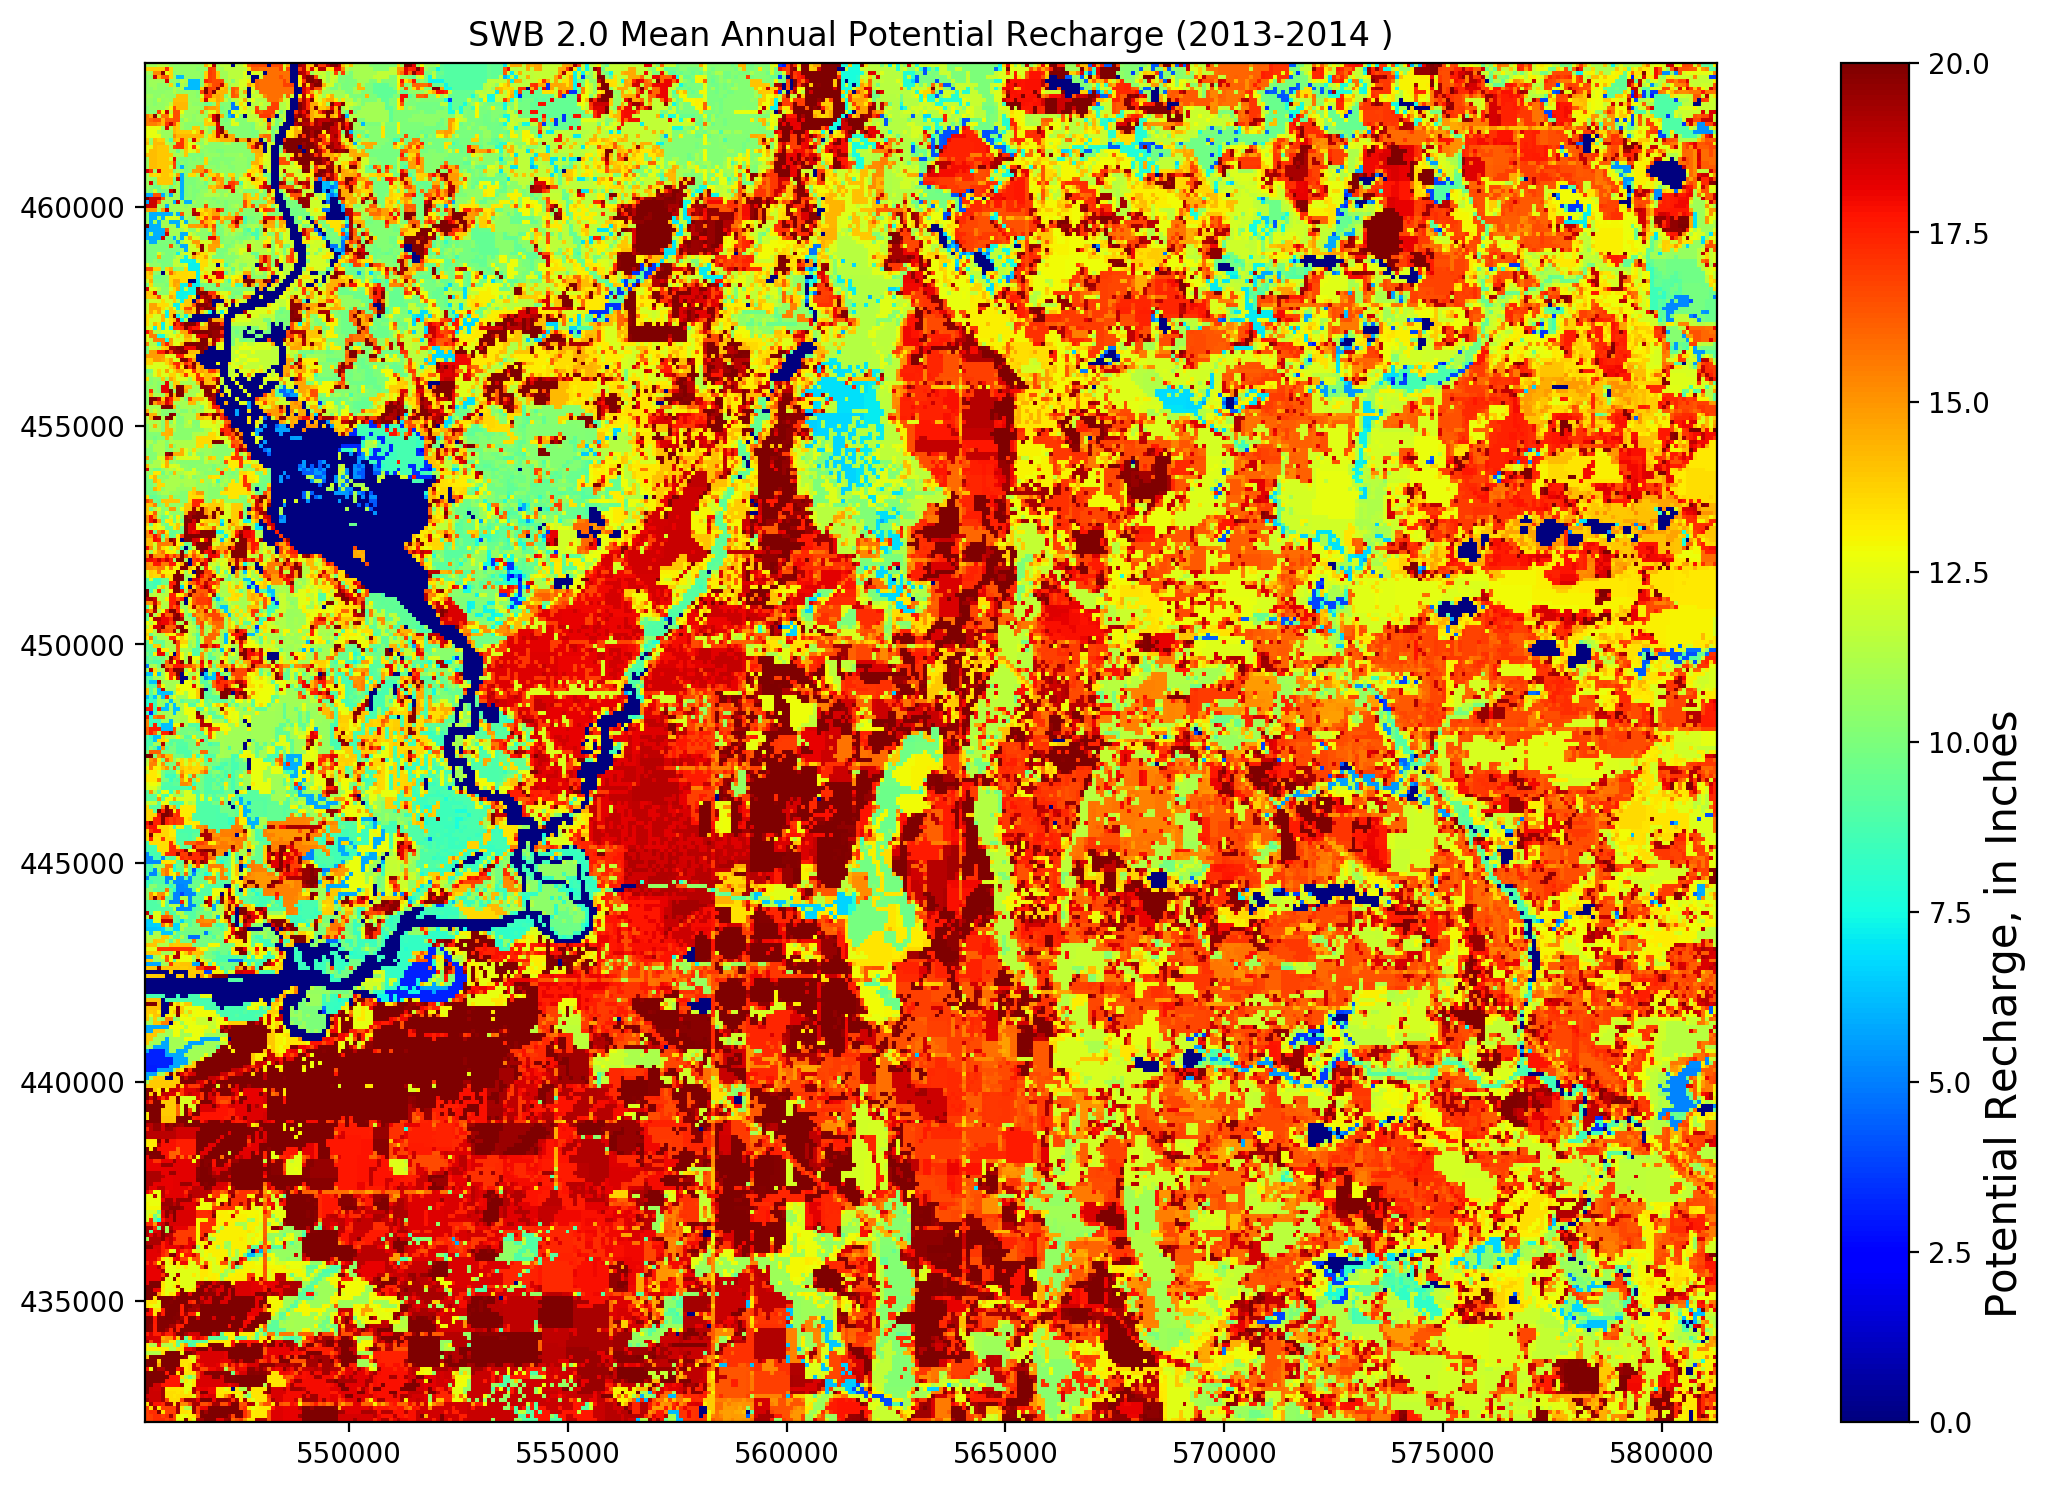

In [4]:
SWB2_values = dataset_swb2.variables[ SWB2_param_name ][366:730, :, :]
# the netCDF values come in with not-a-number (NaN) values in the inactive cells;
# need to deal with these NaNs before doing any processing
SWB2_values = ma.masked_where( np.isnan(SWB2_values), SWB2_values ) 

# sum daily model outputs over the time dimension (axis "0")
SWB2_values = SWB2_values.sum(axis=0) / Simulation_length_in_years

x = dataset_swb2.variables['x'][:]
y = dataset_swb2.variables['y'][:]

make_plot(x=x, y=y, var=SWB2_values, 
          title="SWB 2.0 Mean Annual " + Plot_title_param + " (" 
          + SWB2_start_year + "-" + SWB2_stop_year + " )",
          barlabel=Plot_title_param + Plot_title_units, minz=0., maxz=20. )

### Plot of SWB 1.0 Model output ###

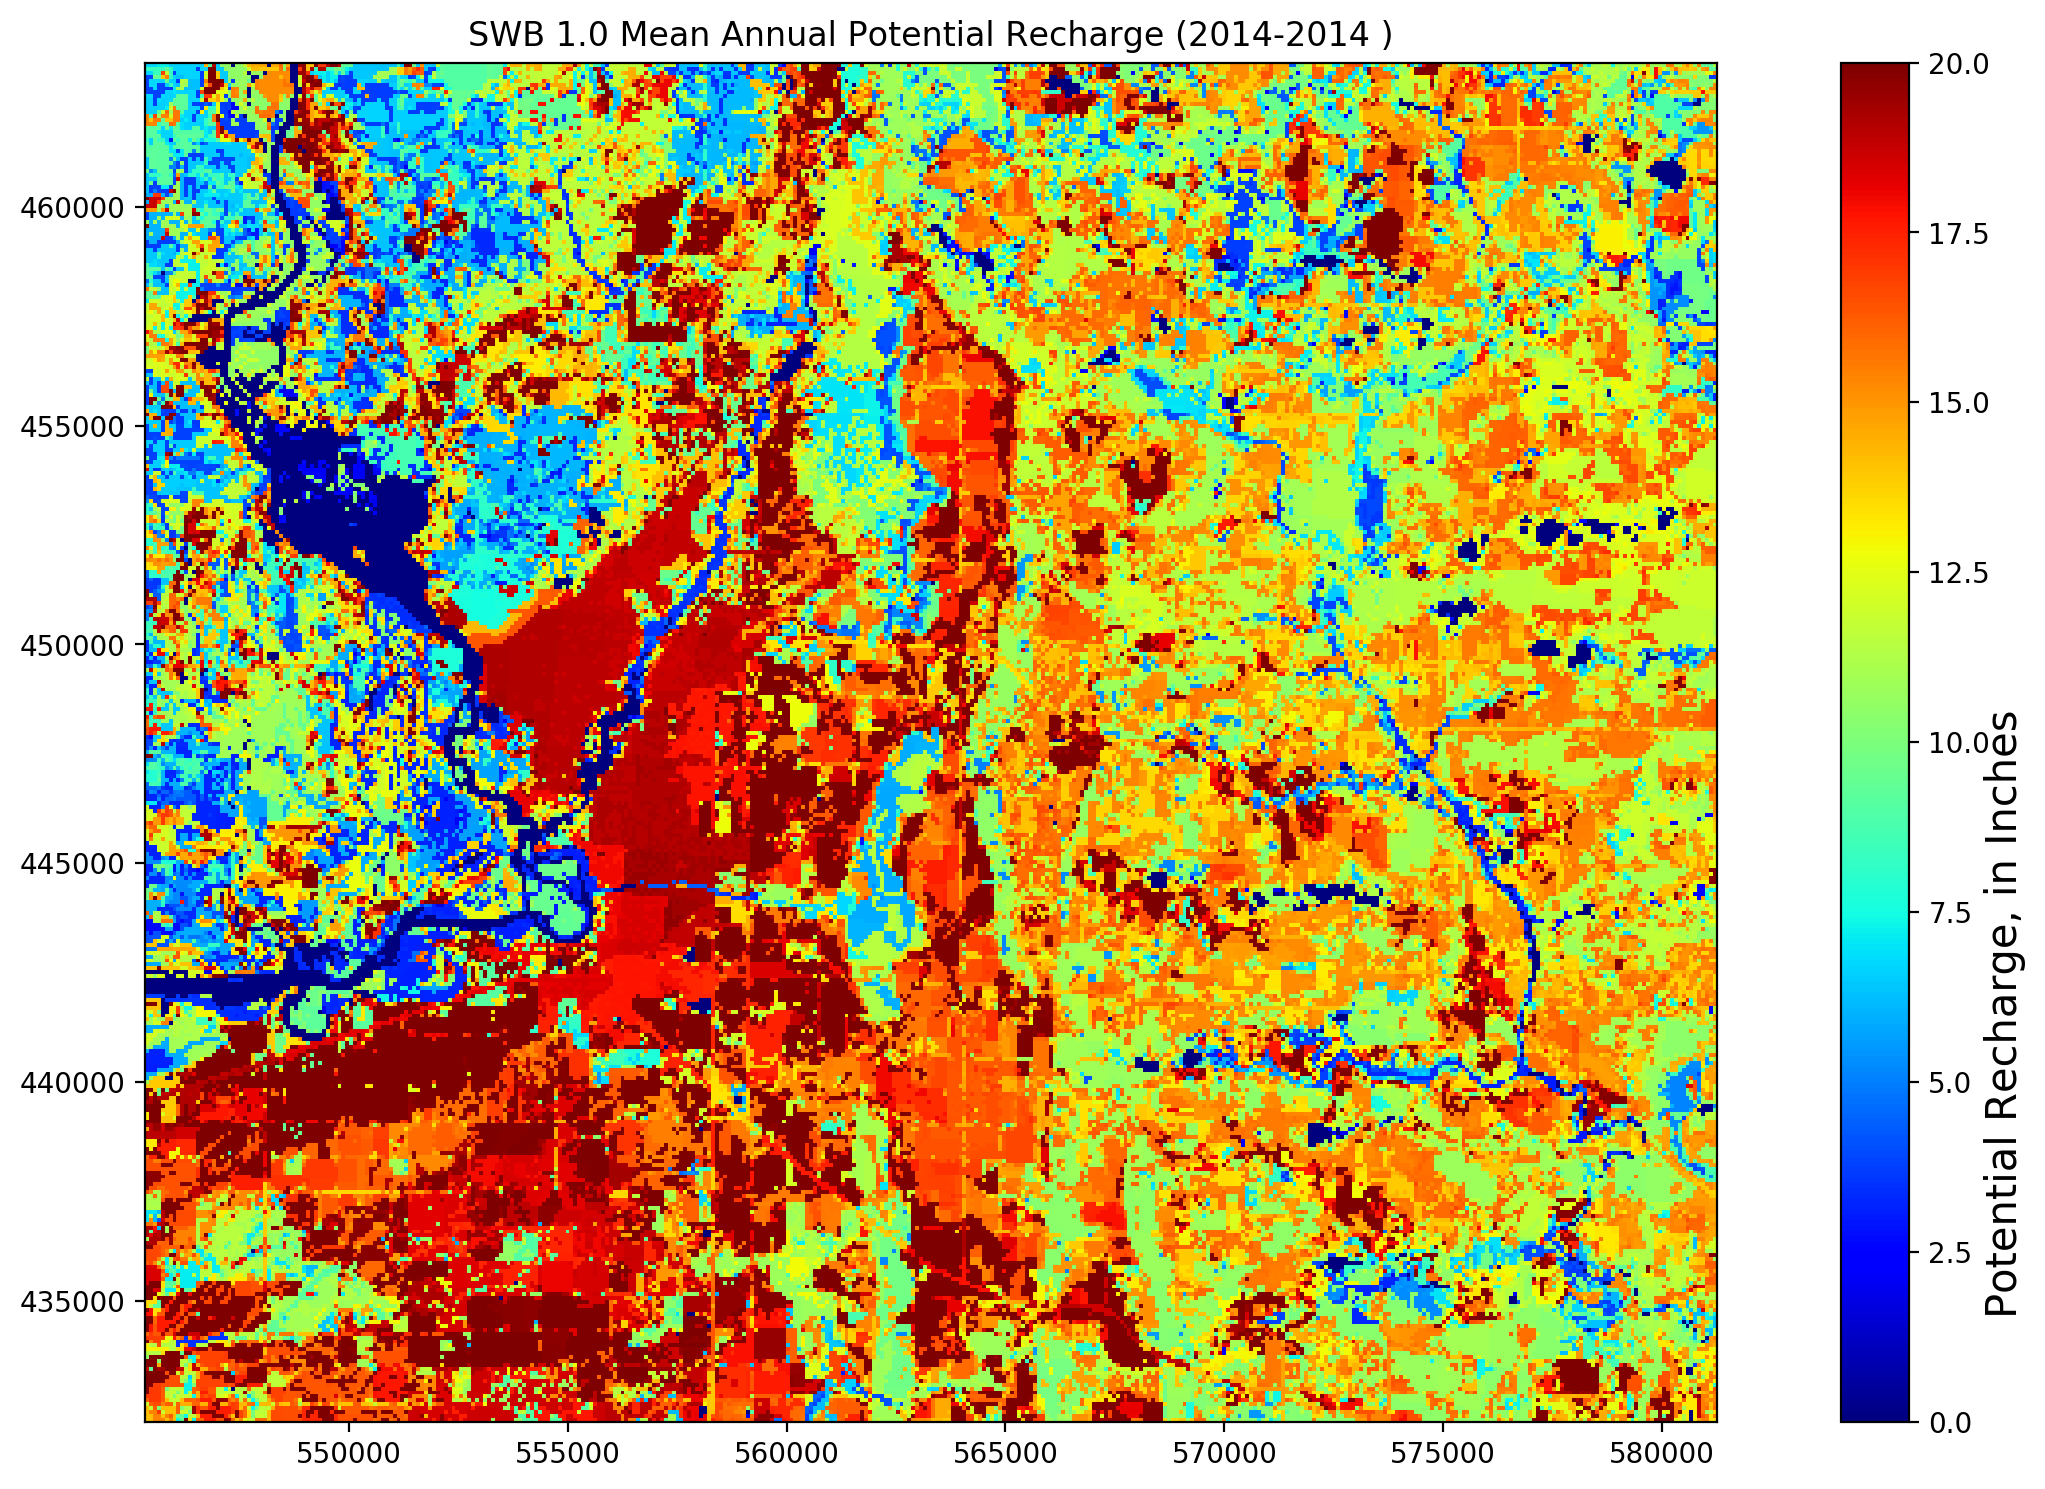

In [5]:
make_plot(x=x, y=y, var=SWB_values,
          title="SWB 1.0 Mean Annual " + Plot_title_param + " (" 
          + SWB_start_year + "-" + SWB_stop_year + " )",
          barlabel=Plot_title_param + Plot_title_units, minz=0., maxz=20. )

### Plot of differences: SWB 2.0 output minus SWB 1.0 output ###

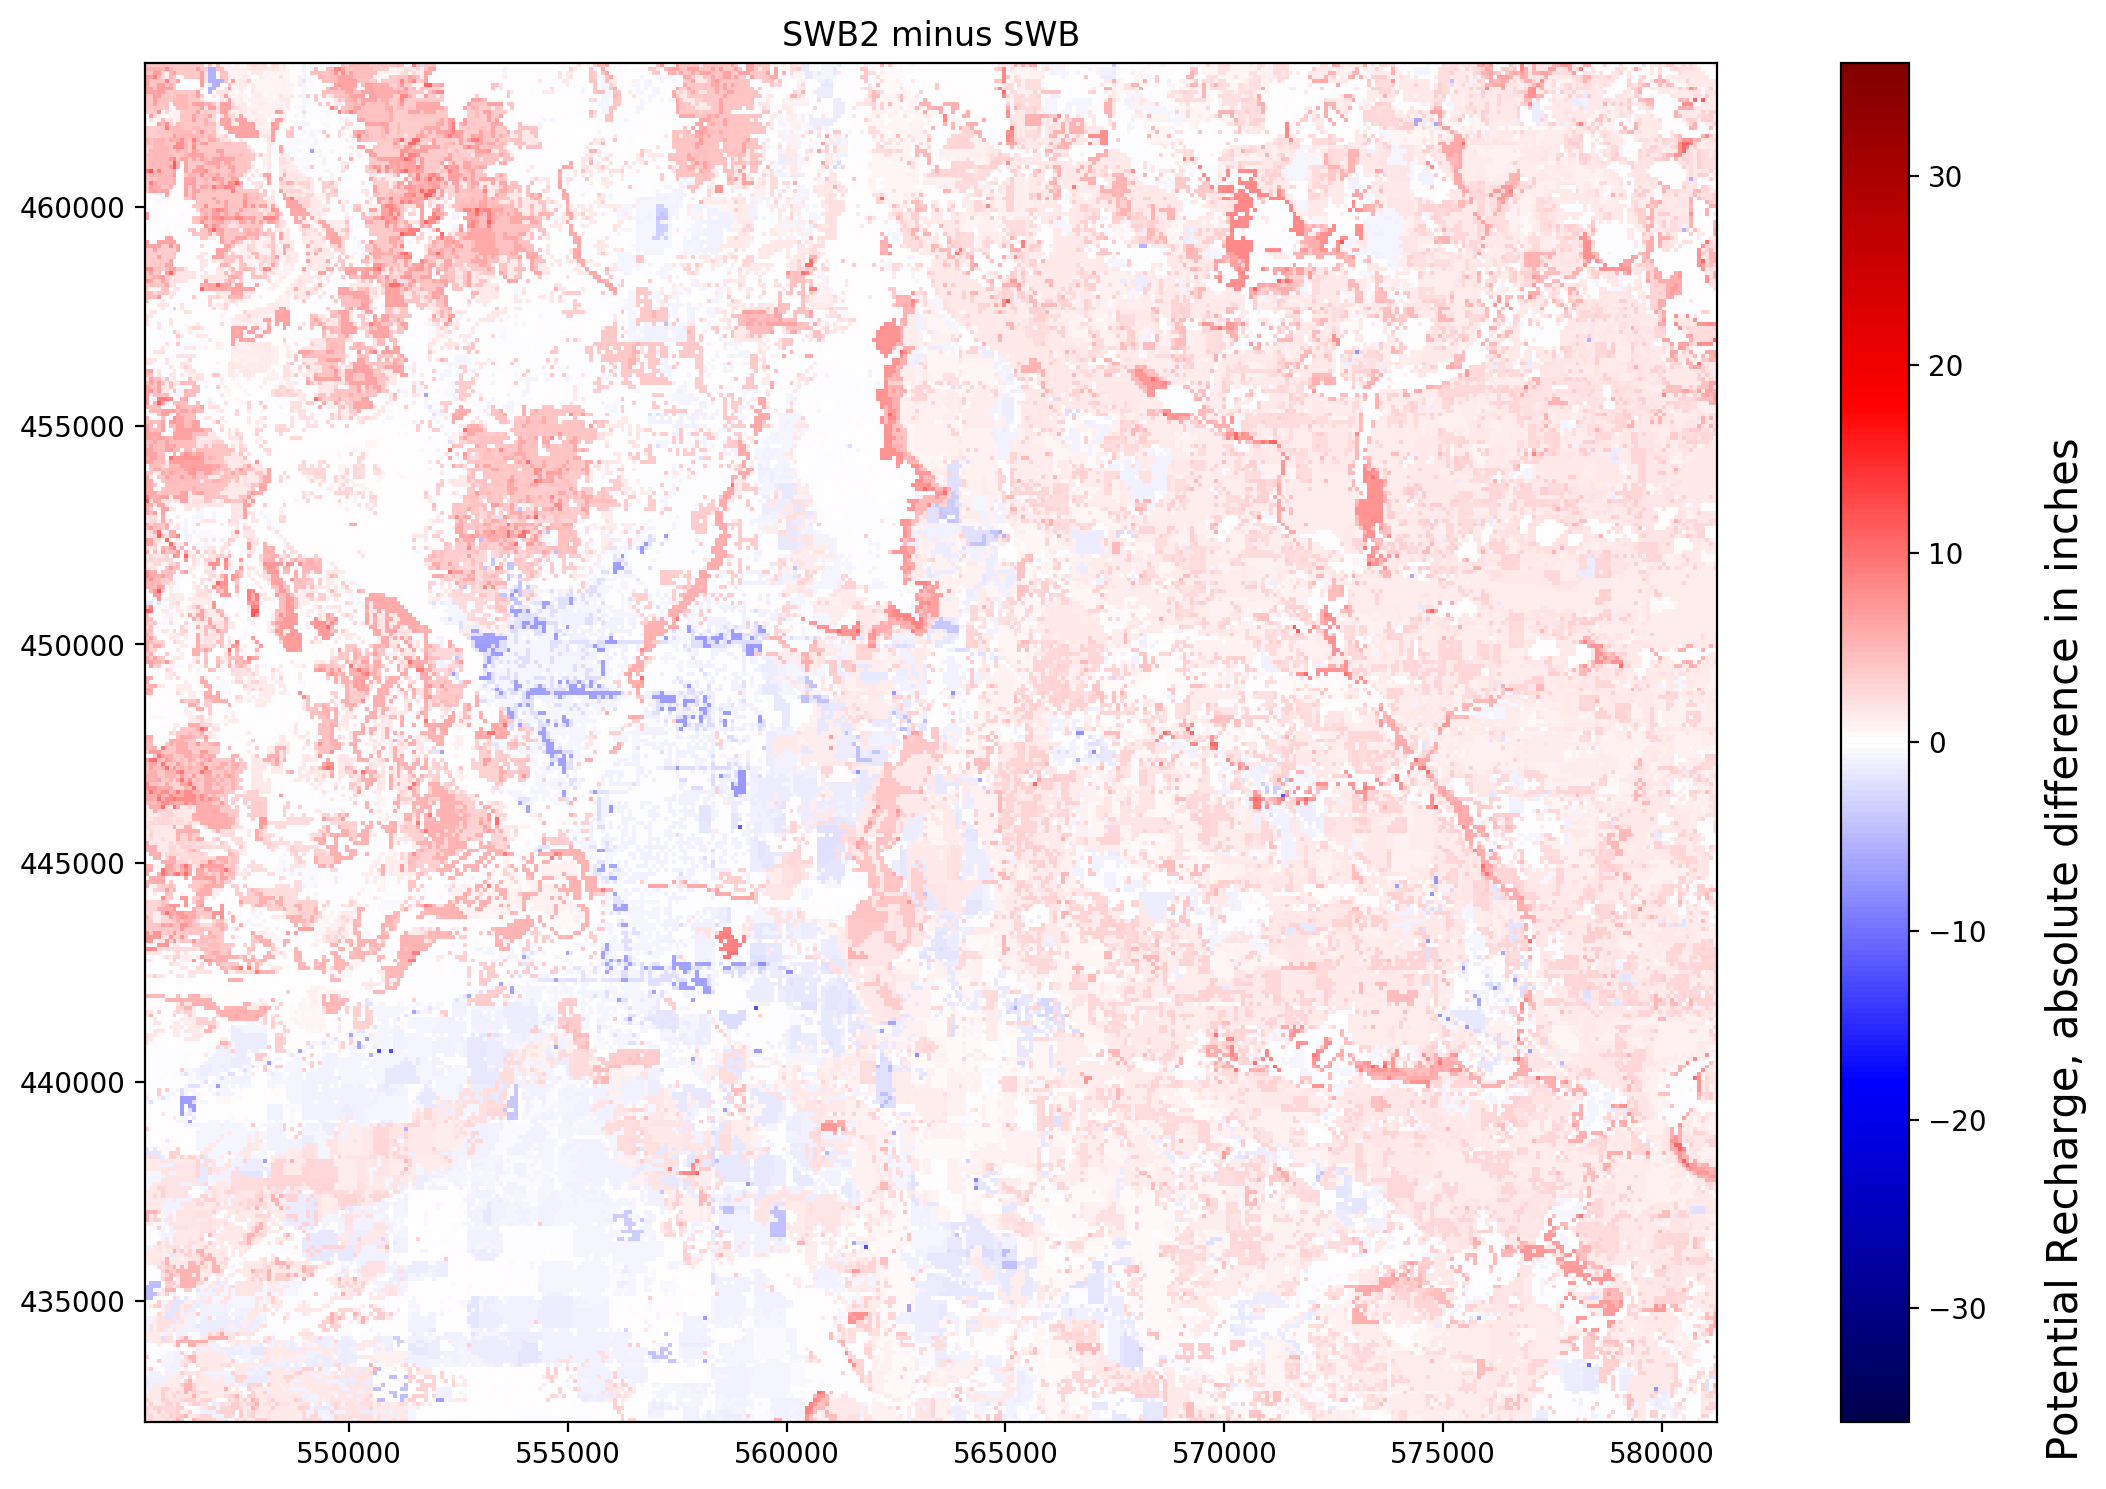

In [6]:
diff = SWB2_values - SWB_values
make_diffplot(x=x, y=y, var=diff,
          title="SWB2 minus SWB",
          barlabel=Plot_title_param + ", absolute difference in inches" )

### Plot of SWB 2.0 and SWB 1.0 model outputs ###

/Users/smwesten/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


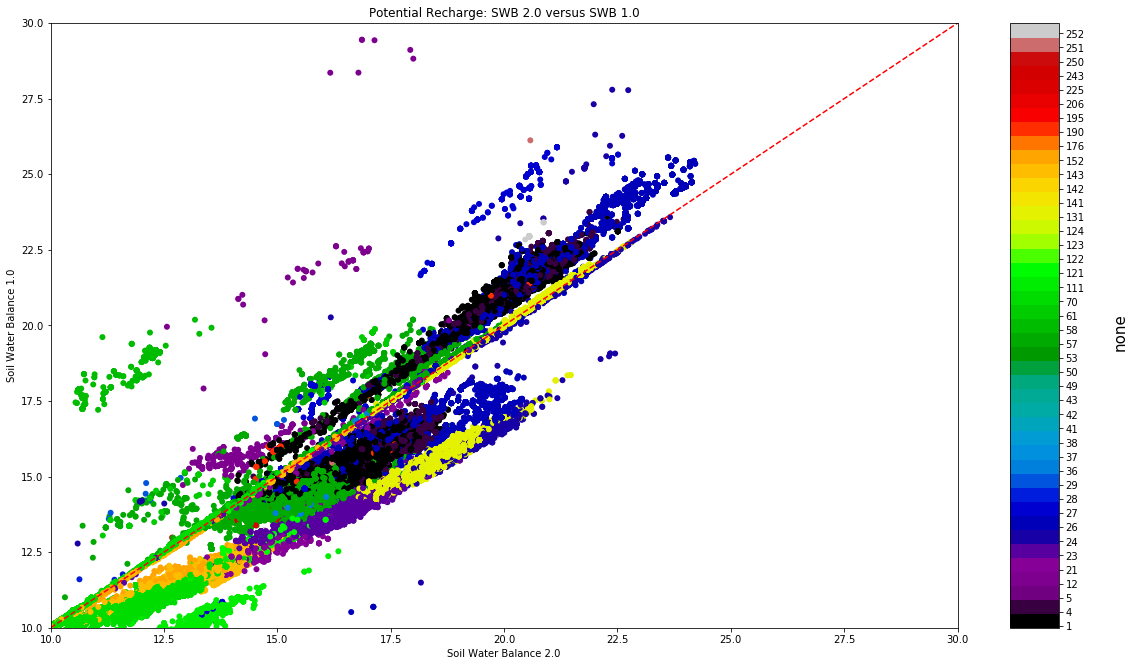

In [7]:
lu = dataset_lu.ReadAsArray()
lu = ma.masked_where( lu <= 0, lu )
lu_vals=np.unique( lu.flatten() )
N=lu_vals.count()
make_scatter(x=SWB2_values, y=SWB_values, color=lu, title=Plot_title_param 
             + ": SWB 2.0 versus SWB 1.0", xlab="Soil Water Balance 2.0",
             ylab="Soil Water Balance 1.0",
            xmin=10, ymin=10, xmax=30, ymax=30, cmap=discrete_cmap(N, "spectral"))

_Comments:_ The color coding above corresponds to the landuse code from the LU_code field in the landuse lookup table. Linear strings of points that do not fall on the 1:1 slope line appear to be caused by mismatches in grid cell coverage and resolution in the various input files.

### Plot of landuse as read in by SWB ###

/Users/smwesten/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


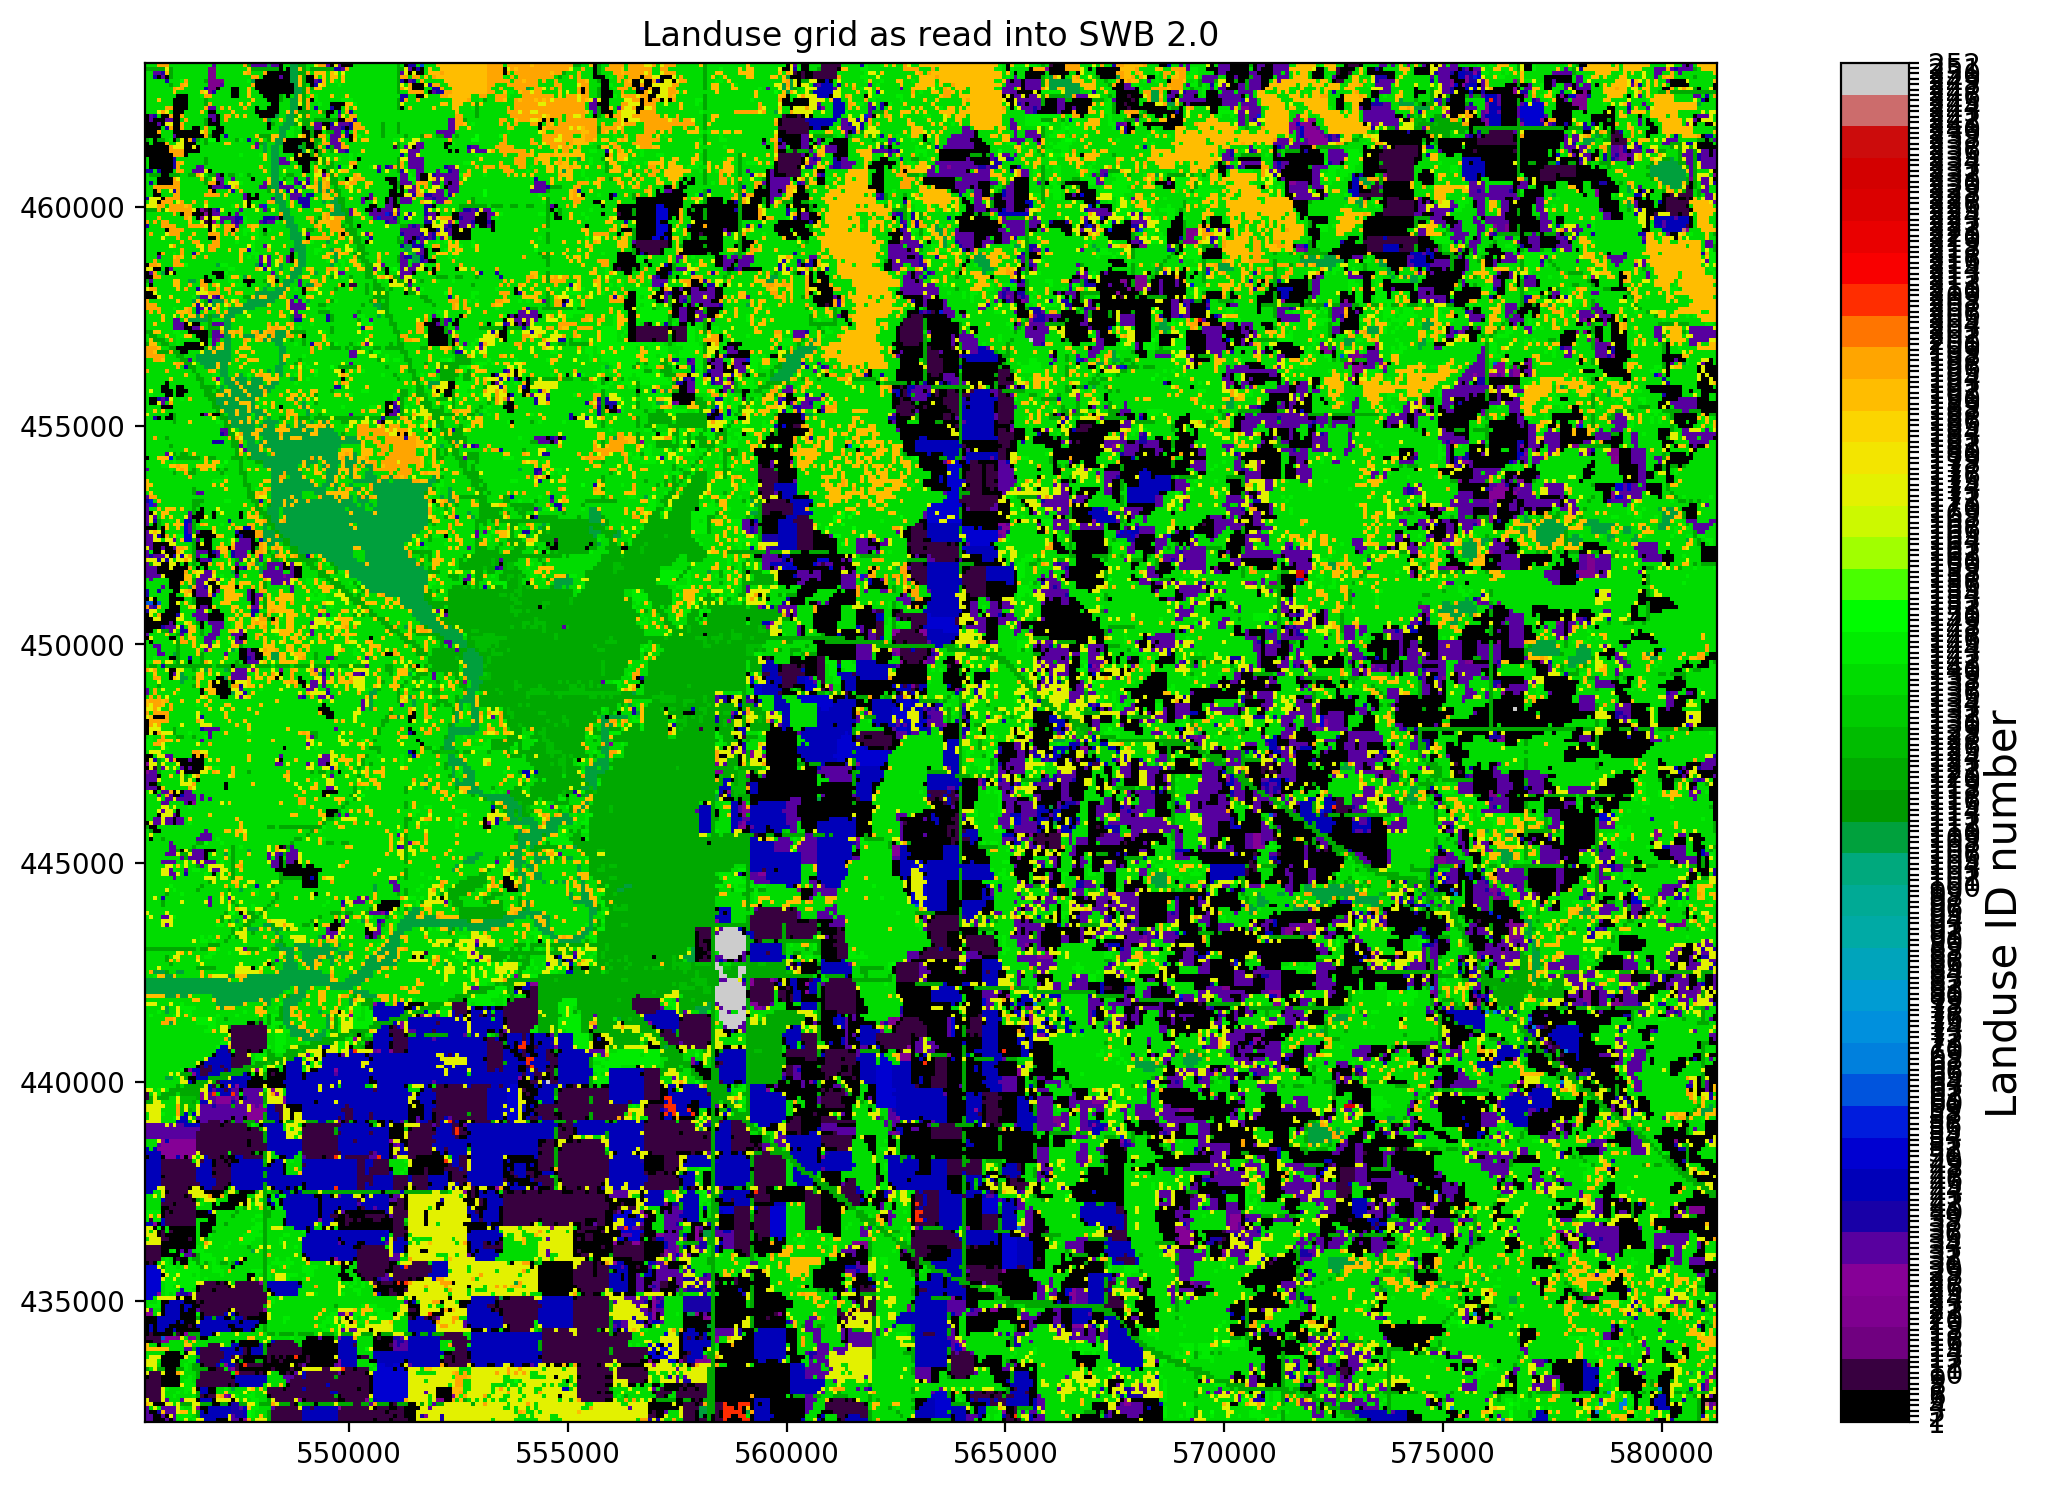

In [8]:
cmap = discrete_cmap(N, "spectral")
make_plot(x=x, y=y, var=lu,
          title="Landuse grid as read into SWB 2.0",
          barlabel="Landuse ID number",
          cmap=cmap, 
          each=True)

### Table of model differences by landuse code ###

In [9]:
np.unique(lu)
lu_descriptions=lu_table['Description']
lu_lookup_values=lu_table['LU_Code']
make_comparison_table( x=SWB2_values, y=SWB_values, factor=lu, 
                       description=lu_descriptions,
                       lookup_vals=lu_lookup_values)

,Code,Description,Count,SWB2 Mean,SWB Mean,Difference
0,1,Corn,20181,17.512,16.769,0.742334
1,4,Sorghum,23,18.679,17.446,1.23236
2,5,Soybeans,2534,16.816,16.593,0.223644
3,12,Sweet Corn,5957,18.928,18.869,0.058609
4,21,Barley,34,16.300,15.051,1.24905
5,23,Spring Wheat,7,15.104,12.049,3.05517
6,24,Winter Wheat,302,14.482,16.810,-2.32814
7,26,Dbl Crop WinWht/Soybeans,5,16.933,17.459,-0.52685
8,27,Rye,358,16.153,14.834,1.31897
9,28,Oats,172,15.912,14.592,1.31979
